# Entropy Measure Cut-off using Post Volume

### 1. Preprocess

In [58]:
# Import Modules
import pandas as pd
import numpy as np
from nltk import FreqDist
import sqlite3
import pickle
import math
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

with open('/data1/StackOverflow/Tag_Analysis/df_tags_2023.pickle', 'rb') as fr:
    df_tags = pickle.load(fr)

def wc(text):
    """
    Cleaning function to be used with our first wordcloud
    """
    
    if text:
        tags = text.replace('><',' ')
        tags = tags.replace('-','')
        tags = tags.replace('.','DOT')
        tags = tags.replace('c++','Cpp')
        tags = tags.replace('c#','Csharp')
        tags = tags.replace('>','')
        return tags.replace('<','')
    else:
        return 'None'
    
def clean_tags(text):
    """
    Cleaning function for tags
    """
    
    if text:
        tags = text.replace('><',' ')
        tags = tags.replace('>','')
        return tags.replace('<','')
    else:
        return 'None'
    
def tag_freq(data):
    tags = data['tags'].str.replace('[\["\]]', '', regex=True)
    tags = [tag for i in tags.apply(lambda x: wc(x)) for tag in i.split(', ')]
    result = FreqDist(tags)
    return result

# Preprocessing
df_tags['creation_date'] = pd.to_datetime(df_tags['creation_date'])
df_tags['year_month'] = df_tags['creation_date'].dt.to_period('D')
df_tags['year_month'] = df_tags['year_month'].astype(str)
year_month = df_tags.year_month.unique()

# load pickle
import pickle
with open('/data1/StackOverflow/diff_in_diff/daily_tagShare_modified.pickle', 'rb') as fr:
    all_keys = pickle.load(fr)

# Split into counts and share vals.
df_count = all_keys.iloc[:,0::2]
df_share = all_keys.drop('tag', axis = 1)
df_share = df_share.iloc[:,0::2]

# df_count로 share 만들어야 함.
tagTrend = {'tagName' : df_count['index'], 'preGPT':
              df_count.iloc[:, 641:731].sum(axis = 1, skipna = True),
              'postGPT' : df_count.iloc[:, 731:].sum(axis = 1, skipna = True)}
tagTrend = pd.DataFrame(tagTrend)
tagTrend['pre_share'] = tagTrend['preGPT'] / tagTrend['preGPT'].sum()
tagTrend['post_share'] = tagTrend['postGPT'] / tagTrend['postGPT'].sum()

# Convert nan to 0
#tagTrend.fillna(0, inplace = True)
tagTrend['diff'] = tagTrend['post_share'] - tagTrend['pre_share']
tagTrend.sort_values('diff', ascending = False)

,tagName,preGPT,postGPT,pre_share,post_share,diff
242,nextDOTjs,3363.0,12004.0,0.002811,0.004239,0.001428
442,springboot,5185.0,15645.0,0.004333,0.005524,0.001191
168,seleniumwebdriver,1149.0,5905.0,0.000960,0.002085,0.001125
29,angular,6128.0,16166.0,0.005121,0.005708,0.000587
10986,openaiapi,58.0,1431.0,0.000048,0.000505,0.000457
...,...,...,...,...,...,...
418,sql,9806.0,18885.0,0.008195,0.006668,-0.001527
28,arrays,6757.0,10368.0,0.005647,0.003661,-0.001986
72,pandas,11336.0,19116.0,0.009474,0.006750,-0.002724
5,javascript,41753.0,85659.0,0.034894,0.030246,-0.004647


### 2. Share Volume Approach

In [59]:
def calculate_entropy(probabilities):
    """ Calculate the Shannon entropy of a given list of probabilities. """
    entropy = 0
    for p in probabilities:
        if p > 0:
            entropy += p * math.log(p, 2)
    return -entropy

In [60]:
# Visualization
def vis_coeff(df_result):
    fig, ax = plt.subplots()
    line, = ax.plot(df_result['cut_off_percentage'].astype(str), df_result['coef'], marker='o', label='Coefficient')  # Added label for legend

    # Adding title and labels
    ax.set_title('Change of Coefficient using Post Volume(E.3.2)')
    ax.set_xlabel('Number of K (Filtered)')
    ax.set_ylabel('Coefficient')

    # Optionally add grid
    ax.grid(True)

    # Adding labels at the top of each point
    for i, txt in enumerate(df_result['volume_outlier'].round(2)):
        ax.text(df_result['cut_off_percentage'].astype(str)[i], df_result['coef'][i]+0.0001, txt, ha='center', va='bottom')

    # Adding text message at the top right corner
    plt.text(1, 0.97, 'The labeled values represent volume of outliers', 
            horizontalalignment='right', 
            verticalalignment='top', 
            transform=ax.transAxes, 
            fontsize=10)
    # Display the plot
    plt.show()

### Further Experience

### This is the final Version

In [61]:
cutoff_List = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
result_vr6 = pd.DataFrame(columns = ['cut_off_percentage', 'coef', 'std_err', 'P_val', 'volume_outlier'])

for i in range(len(cutoff_List)):
    # filter data without outliers
    cleaned_data = tagTrend.sort_values('pre_share', ascending = False)[cutoff_List[i]:]
    cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)
    
    ### Update tag share. ###
    df_count_tmp = cleansed.iloc[:,0::2]
    col_sums = df_count_tmp.iloc[:,1:].sum()
    df_share_tmp = df_count_tmp.iloc[:,1:].div(col_sums, axis = 1)
    df_share_tmp.insert(0,'index', df_count_tmp['index'])

    # Entropy score
    entropy_Score = []
    for j in range(1, df_share_tmp.shape[1]):
        entropy_Score.append(calculate_entropy(df_share_tmp.iloc[:, j]))
    result_entropy = pd.DataFrame({'year_month':year_month, 'ent_Score':entropy_Score})
    
    # Model Construction
    entropy = list(result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().ent_Score) # fixed datetime
    # Split Data
    control_data = pd.DataFrame({'entropy' : entropy[:365],
                'T_d': [0]*len(entropy[:365]),
                'P_t' : [0]*90 + [1]*275})
    treated_data = pd.DataFrame({'entropy' : entropy[365:],
                'T_d': [1]*len(entropy[365:]),
                'P_t' : [0]*90 + [1]*275})
    df_did = pd.concat([control_data, treated_data], axis = 0).reset_index(drop = True)
    # Add date and month feature
    df_did['date'] = result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().year_month
    df_did['month'] = pd.to_datetime(df_did['date']).dt.month
    # Apply log
    df_did['ln_y'] = np.log(df_did['entropy'])

    # Result Appending
    filename = f"entropy_{cutoff_List[i]}.pkl"
    model2 = sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit(cov_type='HC3')
    with open(filename, "wb") as file:
        pickle.dump(model2, file)
    result_model_bottomK = pd.DataFrame({'cut_off_percentage':[cutoff_List[i]], 'coef':[model2.params['T_d:P_t']], 'std_err':[model2.bse['T_d:P_t']], 'P_val':[model2.pvalues['T_d:P_t']],
                                         'volume_outlier': [tagTrend.sort_values('pre_share', ascending = False)[:cutoff_List[i]].pre_share.sum()]})
    result_vr6 = pd.concat([result_vr6, result_model_bottomK], ignore_index = True)

/tmp/ipykernel_3408553/305418937.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_vr6 = pd.concat([result_vr6, result_model_bottomK], ignore_index = True)


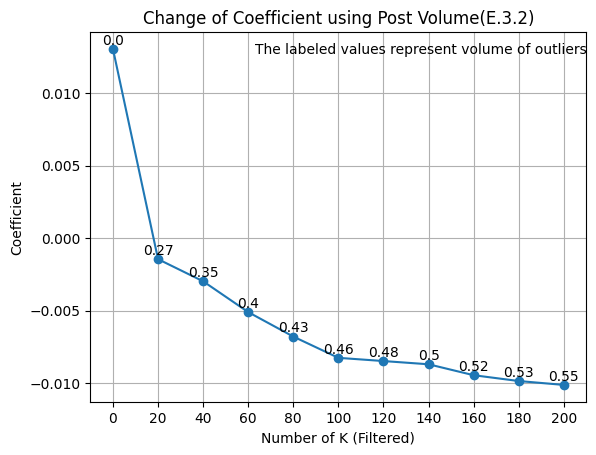

In [62]:
vis_coeff(result_vr6)

In [63]:
cutoff_List = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
result_vr6 = pd.DataFrame(columns = ['cut_off_percentage', 'coef', 'std_err', 'P_val', 'volume_outlier'])

for i in range(len(cutoff_List)):
    # filter data without outliers
    cleaned_data = tagTrend.sort_values('pre_share', ascending = False)[cutoff_List[i]:]
    cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)
    
    ### Update tag share. ###
    df_count_tmp = cleansed.iloc[:,0::2]
    col_sums = df_count_tmp.iloc[:,1:].sum()
    df_share_tmp = df_count_tmp.iloc[:,1:].div(col_sums, axis = 1)
    df_share_tmp.insert(0,'index', df_count_tmp['index'])

    # Entropy score
    entropy_Score = []
    for j in range(1, df_share_tmp.shape[1]):
        entropy_Score.append(calculate_entropy(df_share_tmp.iloc[:, j]))
    result_entropy = pd.DataFrame({'year_month':year_month, 'ent_Score':entropy_Score})
    
    # Model Construction
    entropy = list(result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().ent_Score) # fixed datetime
    # Split Data
    control_data = pd.DataFrame({'entropy' : entropy[:365],
                'T_d': [0]*len(entropy[:365]),
                'P_t' : [0]*90 + [1]*275})
    treated_data = pd.DataFrame({'entropy' : entropy[365:],
                'T_d': [1]*len(entropy[365:]),
                'P_t' : [0]*90 + [1]*275})
    df_did = pd.concat([control_data, treated_data], axis = 0).reset_index(drop = True)
    # Add date and month feature
    df_did['date'] = result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().year_month
    df_did['month'] = pd.to_datetime(df_did['date']).dt.month
    # Apply log
    df_did['ln_y'] = np.log(df_did['entropy'])

    # Result Appending
    filename = f"entropy_{cutoff_List[i]}.pkl"
    model2 = sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit(cov_type='HC3')
    result_model_bottomK = pd.DataFrame({'cut_off_percentage':[cutoff_List[i]], 'coef':[model2.params['T_d:P_t']], 'std_err':[model2.bse['T_d:P_t']], 'P_val':[model2.pvalues['T_d:P_t']],
                                         'volume_outlier': [tagTrend.sort_values('pre_share', ascending = False)[:cutoff_List[i]].pre_share.sum()]})
    result_vr6 = pd.concat([result_vr6, result_model_bottomK], ignore_index = True)

/tmp/ipykernel_3408553/709952966.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_vr6 = pd.concat([result_vr6, result_model_bottomK], ignore_index = True)


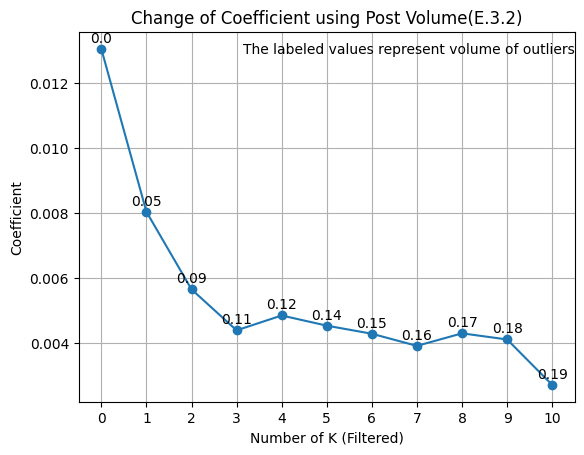

In [64]:
vis_coeff(result_vr6)

In [37]:
with open("entropy_0.pkl", "rb") as file:
    # Deserialize the object from the file
    model_ent = pickle.load(file)

In [38]:
model_ent.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ln_y   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     31.00
Date:                Mon, 20 May 2024   Prob (F-statistic):           2.10e-64
Time:                        12:01:24   Log-Likelihood:                 952.80
No. Observations:                 730   AIC:                            -1876.
Df Residuals:                     715   BIC:                            -1807.
Df Model:                          14                                         
Covariance Type:                  HC3                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.6379      0.023    242.905      0.000       5.592       5.683
C(month)[T.2]      0.0158      0.012      1.342      0.179      -0.007       0.039
C(month)[T.3]      0.0163      0.012      1.404      0.160      -0.006       0.039
C(month)[T.4]     -0.0047      0.012     -0.378      0.706      -0.029       0.020
C(month)[T.5]     -0.0018      0.012     -0.153      0.879      -0.026       0.022
C(month)[T.6]      0.0075      0.012      0.611      0.541      -0.017       0.032
C(month)[T.7]     -0.0036      0.013     -0.282      0.778      -0.028       0.021
C(month)[T.8]      0.0128      0.012      1.071      0.284      -0.011       0.036
C(month)[T.9]      0.0208      0.024      0.859      0.390      -0.027       0.068
C(month)[T.10]     0.0157      0.024      0.646      0.518      -0.032       0.063
C(month)[T.11]     0.0390      0.021      1.845      0.065      -0.002       0.080
C(month)[T.12]    -0.0191      0.012     -1.633      0.103      -0.042       0.004
T_d                0.0657      0.010      6.794      0.000       0.047       0.085
P_t                0.0257      0.022      1.175      0.240      -0.017       0.068
T_d:P_t            0.0405      0.011      3.598      0.000       0.018       0.063
==============================================================================
Omnibus:                      139.223   Durbin-Watson:                   1.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              116.006
Skew:                          -0.885   Prob(JB):                     6.45e-26
Kurtosis:                       2.174   Cond. No.                         65.2
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""